Book Recommender System using [Book Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

# Book Recommender System

### Importing Usual Libraries

In [1]:
import os
import re
import nltk
import requests
import warnings
import numpy as np          # linear algebra
import pandas as pd         # data processing
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings; warnings.simplefilter('ignore')
from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bookcrossing-dataset/Books Data with Category Language and Summary/Preprocessed_data.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv


## Corrections :

1. The 'Book Crossing' dataset contains a large number of ampersand(&) charecters whose HTML entity is "&amp;". Since the delimeter of this dataset is semicolon(;), the "&amp;" tends to break few lines in the dataset while transforming them into a dataframe. HTML preprocessing solved that issue.

2. There are also many python escape sequences for Double Quotes (\"). The escape charecters make a shift in values of the fields. In a sense that some Publisher's name was shifted backwards in the field of 'Year-Of-Publication'. Some whitespace charecters were also breaking the lines. These were solved by the 'escapechar' and 'skipinitialspace' parameters. 

3. Inside the names of the books some semicolons were also contributing in the shifting of the values, 'quotechar' parameter solved that since it helps to ignore the delimeter inside the string. 

4. Overall, solving these issues made some next preprocessing steps irrelevent. The 'Year-Of-Publication' field were mixture of integer and string values, which is not anymore the case. So there's no need to change the data types to 'int' and solve the shifting of the values manually with the function (commented out now).

### Importing Dataset

In [2]:
import html
with open('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv', 'r', encoding='latin-1') as f, open('book_data_fixed.csv', 'w') as g:
    content = html.unescape(f.read())
    g.write(content)

book_data = pd.read_csv('book_data_fixed.csv', skipinitialspace = True, sep=';', quotechar = '"', escapechar = '\\')
book_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
book_data.shape

(271379, 8)

In [4]:
user_data= pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv', sep= ';', encoding= 'latin-1')
user_data.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
rating_data= pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv', sep= ';', encoding= 'latin-1')
rating_data.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Data Preprocessing

At first, I'll investigate the tables to see if any improvement is needed. Then I will do necessary operations to make the data clean so that I can work better with them.

In [6]:
book_data.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis= 1, inplace= True)
book_data.columns= book_data.columns.str.strip().str.lower().str.replace('-', '_')
user_data.columns= user_data.columns.str.strip().str.lower().str.replace('-', '_')
rating_data.columns= rating_data.columns.str.strip().str.lower().str.replace('-', '_')

In [7]:
pd.set_option('display.max_colwidth', -1)

In [8]:
print(book_data.dtypes)
print('-'*40)
print(book_data.isnull().sum())

isbn                   object
book_title             object
book_author            object
year_of_publication    int64 
publisher              object
dtype: object
----------------------------------------
isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
dtype: int64


Fixing the missing value problem in 'book_author' column.

In [9]:
book_data.loc[(book_data['book_author'].isnull()),: ]

,isbn,book_title,book_author,year_of_publication,publisher
187700,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [10]:
book_data.loc[(book_data['isbn'] == '9627982032'),'book_author'] = 'other'

Look at the unique years to realize the time period as this dataset was created in 2004. 

In [11]:
book_data['year_of_publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037])

So the corrections are made. We've seen there are two missing values in the 'publisher' column. Let's take care of that.

In [12]:
book_data.loc[(book_data['publisher'].isnull()),'publisher'] = 'no mention'

In [13]:
print(book_data['publisher'].isnull().sum())

0


Let's investigate the user_rating dataset

In [14]:
print(user_data.shape)

(278858, 3)


In [15]:
user_data['user_id'].unique()

array([     1,      2,      3, ..., 278856, 278857, 278858])

So user_id's alright. Let's check out the age of the users.

In [16]:
user_data['age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

In [17]:
user_data.loc[(user_data['age'] > 90) | (user_data['age'] < 5)] = np.nan
user_data['age'].fillna((user_data['age'].mean()), inplace=True)
user_data['age']= user_data['age'].astype('int64')
user_data['age'].unique()

array([34, 18, 17, 61, 26, 14, 25, 19, 46, 55, 32, 24, 20, 23, 51, 31, 21,
       44, 30, 57, 43, 37, 41, 54, 42, 50, 39, 53, 47, 36, 28, 35, 13, 58,
       49, 38, 45, 62, 63, 27, 33, 29, 66, 40, 15, 60, 79, 22, 16, 65, 59,
       48, 72, 56, 67, 80, 52, 69, 71, 73, 78,  9, 64, 12, 74, 75, 76, 83,
       68, 11, 77, 70,  8,  7, 81, 10,  5,  6, 84, 82, 90, 85, 86, 87, 89,
       88])

We need to investigate out rating dataset too. 

In [18]:
rating_data.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


We'll only take the ISBNs that also belongs to the main book_data set.

In [19]:
unique_ratings = rating_data[rating_data.isbn.isin(book_data.isbn)]

Ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset

In [20]:
rating_data = rating_data[rating_data.user_id.isin(user_data.user_id)]

In [21]:
print(rating_data.shape)
print(unique_ratings.shape)
print(book_data.shape)
print(user_data.shape)

(1142978, 3)
(1031175, 3)
(271379, 5)
(278858, 3)


In [22]:
unique_ratings['book_rating'].unique()

array([ 0,  5,  3,  6,  7,  9,  8, 10,  1,  4,  2])

## Visualization

Let's now make some pretty plots to visualize the data. 

The age distribution of the readers: 

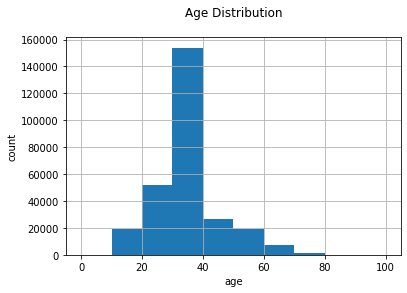

In [23]:
user_data.age.hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title('Age Distribution\n')
plt.xlabel('age')
plt.ylabel('count')
plt.savefig('age_dist.png', bbox_inches='tight')
plt.show()

Let's see which rating people tend to give more : 

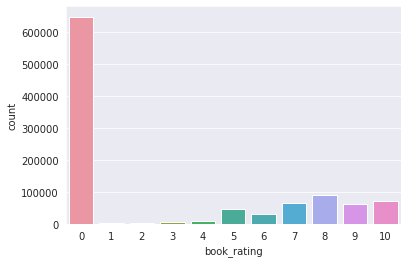

In [24]:
sns.set_style('darkgrid')
sns.countplot(data= unique_ratings , x='book_rating')
plt.show()

This countplot shows users have rated 0 the most, which can mean they haven't rated bokks at all. We have to separate the explicit ratings represented by 1–10 and implicit ratings represented by 0.

In [25]:
ratings_explicit= unique_ratings[unique_ratings['book_rating'] != 0]
ratings_implicit= unique_ratings[unique_ratings['book_rating'] == 0]

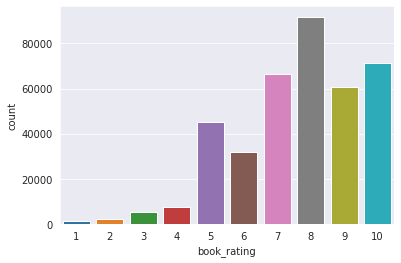

In [26]:
sns.set_style('darkgrid')
sns.countplot(data= ratings_explicit , x='book_rating')
plt.show()

Now this countplot of book_rating indicates that higher ratings are more common amongst users and rating 8 has been rated highest number of times.

 As the problem of string 'year_of _publication' values was solved in the preprocessing steps, so now there's no need to convert the data types anymore and the code is commented out. Below the plot says there are 4619 'year_of_publication' values ranging from 0-99 which were not visible in the previous notebook. So, we plotted this interactive plot to see more accurately the 'year_of _publication' distribution. 

In [27]:
import plotly.express as px

fig = px.histogram(book_data, x = "year_of_publication", nbins = 30, width = 800, height = 500)
fig.update_xaxes(tick0 = 0 , dtick = 1000)
fig.show()

### Popularity Based Recommendation

Now let's try to build our first recommendation system based on popularity. This recommendations are usually given to every user irrespective of personal charecterization. 

In [28]:
ratings_explicit.head()

,user_id,isbn,book_rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [29]:
print(unique_ratings.shape)
print(ratings_explicit.shape)

(1031175, 3)
(383852, 3)


We'll only consider ISBNs that were explicitely rated for this recommendation system.

In [30]:
new_book_df= pd.merge(book_data, ratings_explicit, on='isbn')
new_book_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,116866,9
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,123629,9


In [31]:
print(new_book_df.shape)

(383852, 7)


In [32]:
new_book_df['book_title'].nunique()

135573

In [33]:
top_ten_books= pd.DataFrame(new_book_df.groupby('book_title')['book_rating'].count()
                         .sort_values(ascending=False).head(10))

print('The top ten books recommendation : ')
top_ten_books

The top ten books recommendation : 


,book_rating
book_title,
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,494
The Secret Life of Bees,406
The Nanny Diaries: A Novel,393
The Red Tent (Bestselling Backlist),383
Bridget Jones's Diary,377
A Painted House,366
Life of Pi,336


So our 'All Time Favourite" book recommendations are ready.

### Memory-Based Collaborative Filtering

Memory-Based Collaborative Filtering are of two kinds: 
1. user-item filtering 
2. item-item filtering

A user-item filtering will take a particular user and find users that are similar to that user based on similarity of ratings. Then it will recommend items that are similar to the ones the users liked.

Unlike user-item filtering, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and recommends other items.

* Item-Item Collaborative Filtering: “Users who liked this item also liked …”
* User-Item Collaborative Filtering: “Users who are similar to you also liked …”

### Train - Test Split

In [34]:
from sklearn import model_selection
train_data, test_data = model_selection.train_test_split(new_book_df, test_size=0.20)

In [35]:
print(f'Training set lengths: {len(train_data)}')
print(f'Testing set lengths: {len(test_data)}')
print(f'Test set is {(len(test_data)/(len(train_data)+len(test_data))*100):.0f}% of the full dataset.')

Training set lengths: 307081
Testing set lengths: 76771
Test set is 20% of the full dataset.


In [36]:
# Get int mapping for user_id in train dataset

u_unique_train = train_data.user_id.unique()  
train_data_user2idx = {o:i for i, o in enumerate(u_unique_train)}

# Get int mapping for isbn in train dataset

i_unique_train = train_data.isbn.unique()  
train_data_book2idx = {o:i for i, o in enumerate(i_unique_train)}

# Get int mapping for user_id in test dataset

u_unique_test = test_data.user_id.unique()  
test_data_user2idx = {o:i for i, o in enumerate(u_unique_test)}

# Get int mapping for isbn in train dataset

i_unique_test = test_data.isbn.unique() 
test_data_book2idx = {o:i for i, o in enumerate(i_unique_test)}


In [37]:
# TRAINING SET
train_data['u_unique'] = train_data['user_id'].map(train_data_user2idx)
train_data['i_unique'] = train_data['isbn'].map(train_data_book2idx)

# TESTING SET
test_data['u_unique'] = test_data['user_id'].map(test_data_user2idx)
test_data['i_unique'] = test_data['isbn'].map(test_data_book2idx)

# Convert back to 3-column df
train_data = train_data[['u_unique', 'i_unique', 'book_rating']]
test_data = test_data[['u_unique', 'i_unique', 'book_rating']]

In [38]:
train_data.sample(5)

,u_unique,i_unique,book_rating
49164,21413,7655,5
122526,4174,85583,6
344167,31422,102082,10
274126,471,114117,9
182359,5539,33637,8


### User-Item Matrix for Train Data

At first we'll create an empty matrix of users * books and the will add the appropriate values to the matrix by extracting them from the dataset.

In [39]:
n_users = train_data['u_unique'].nunique()
n_books = train_data['i_unique'].nunique()

train_matrix = np.zeros((n_users, n_books))

for entry in train_data.itertuples():                  # entry[1] is the user-id, entry[2] is the book-isbn
    train_matrix[entry[1]-1, entry[2]-1] = entry[3]    # -1 is to counter 0-based indexing

In [40]:
train_matrix.shape

(59856, 129000)

### User-Item Matrix for Test Data

In [41]:
n_users = test_data['u_unique'].nunique()
n_books = test_data['i_unique'].nunique()

test_matrix = np.zeros((n_users, n_books))

for entry in test_data.itertuples():
    test_matrix[entry[1]-1, entry[2]-1] = entry[3] 

In [42]:
test_matrix.shape

(26020, 46857)

### Cosine Similarity Based Recommendation System

As I am doing this calculations on my PC, so it is not a good idea to perform this huge calculation. So I'll perform on a subset initially. It will take a bit of time to calculate.

A distance metric commonly used in recommender systems is *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors. 

To make item-item similarity we need to take the transpose of the matrix.

In [43]:
train_matrix_small = train_matrix[:5000, :5000]
test_matrix_small = test_matrix[:5000, :5000]

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix_small, metric='cosine')
item_similarity = pairwise_distances(train_matrix_small.T, metric='cosine') 

Now I'll define a function to predict the similarity :

In [44]:
def predict_books(ratings, similarity, type='user'): # default type is 'user'
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        
        # Use np.newaxis so that mean_user_rating has the same format as ratings
        
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [45]:
item_prediction = predict_books(train_matrix_small, item_similarity, type='item')
user_prediction = predict_books(train_matrix_small, user_similarity, type='user')

### Evaluation

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, test_matrix):
    prediction = prediction[test_matrix.nonzero()].flatten()
    test_matrix = test_matrix[test_matrix.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, test_matrix))

print(f'Item-based CF RMSE: {rmse(item_prediction, test_matrix_small)}')
print(f'User-based CF RMSE: {rmse(user_prediction, test_matrix_small)}')


Item-based CF RMSE: 7.976079793930426
User-based CF RMSE: 7.974950128254196


* We see our recommendation system gives 7.94 RMSE score. I want to check if we can make any improvement in this score by using another method. For this I will use Single valu decomposition method from the Surprise library.

### SVD Based recommendation System

In [47]:
from surprise import Reader, Dataset

# Creating a 'Reader' object to set the limit of the ratings 

reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(ratings_explicit, reader)

In [48]:
from surprise import SVD, model_selection, accuracy

model = SVD()

# Train on books dataset

%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6400  1.6380  1.6282  1.6262  1.6489  1.6363  0.0083  
Fit time          24.50   24.56   24.69   24.71   24.55   24.60   0.08    
Test time         0.69    0.67    0.96    1.00    0.70    0.81    0.15    
CPU times: user 2min 14s, sys: 445 ms, total: 2min 14s
Wall time: 2min 14s


{'test_rmse': array([1.63997254, 1.6380213 , 1.62820977, 1.62621567, 1.64889365]),
 'fit_time': (24.50409770011902,
  24.56243658065796,
  24.685221672058105,
  24.707362413406372,
  24.552666664123535),
 'test_time': (0.693211555480957,
  0.6698458194732666,
  0.9635963439941406,
  1.0030105113983154,
  0.6992919445037842)}

### Train - Test Split

In [49]:
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

model = SVD()

model.fit(trainset)
predictions = model.test(testset)

accuracy.rmse(predictions)

RMSE: 1.6397


1.6396884852065807

We see the RMSE score has improved a lot. It is now on average 1.64 which is pretty good. 

### Testing Results !

Let's take an arbitrary user-id and item-id to test our model. 

In [50]:
uid = 276744  
iid = '038550120X' 
pred = model.predict(uid, iid, verbose=True)

user: 276744     item: 038550120X r_ui = None   est = 7.49   {'was_impossible': False}


In [51]:
print(f'The estimated rating for the book with ISBN code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg= ratings_explicit[(ratings_explicit.user_id==pred.uid) & 
                             (ratings_explicit.isbn==pred.iid)].book_rating.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')

The estimated rating for the book with ISBN code 038550120X from user #276744 is 7.49.

The real rating given for this was 7.00.


In [52]:
# The following function was adapted from the surprise docs
# and can be used to get the top book recommendations for each user.
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [53]:
pred = model.test(testset)
top_n = get_top_n(pred)

In [54]:
def get_reading_list(userid):
    """
    Retrieve full book titles from full 'books_users_ratings' dataframe
    """
    reading_list = defaultdict(list)
    top_n = get_top_n(pred, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = new_book_df.loc[new_book_df.isbn==book].book_title.unique()[0]
        reading_list[title] = rating
    return reading_list

In [55]:
# Just take a random look at user_id=116866
example_reading_list = get_reading_list(userid = 116866)
for book, rating in example_reading_list.items():
    print(f'{book}: {rating}')

Algebra and Trigonometry, Unit Circle (6th Edition): 7.889142329163595
Lucy: The Beginnings of Humankind: 7.889142329163595
In the Suicide Mountains: 7.889142329163595
An Introduction to Stochastic Modeling: 7.889142329163595
Calculus: Early Transcendental Functions: 7.889142329163595
Prairyerth: (A Deep Map (A Deep Map): 7.889142329163595
Isaac Newton: The Last Sorcerer (Helix Books): 7.889142329163595
Deep Time: How Humanity Communicates Across Millennia: 7.889142329163595
Statistical Inference (The Wadsworth & Brooks/Cole Statistics/Probability Series): 7.889142329163595
Particle Physics: A Los Alamos Primer: 7.889142329163595
